# 2. Stereo-seq Hemibrian

Here, we analyzed the mouse brain data generated from Stereo-seq, including cortical regions, hippocampal regions, midbrain regions, thalamic regions, and fiber tracts. Raw data are avaiable at https://db.cngb.org/stomics/mosta/.

## load data

In [1]:
import os
os.chdir('/home/yangludong/yyy/tutorial')
os.environ['R_HOME'] = '/home/yangludong/anaconda3/envs/yyy2/lib/R' #path to your R installation
os.environ['R_USER'] = '/home/yangludong/anaconda3/envs/yyy2/lib/python3.8/site-packages/rpy2' #path depends on where you installed Python. Mine is the Anaconda distribution

import warnings
warnings.filterwarnings('ignore')

import SECE
import torch
import numpy as np
import scanpy as sc

def set_seed(seed):
    import random 
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

seed = 300
set_seed(seed)
result_path = 'brain_'
os.makedirs(result_path, exist_ok=True)

In [2]:
adata = sc.read('./data/brain.h5ad')
sc.pp.filter_genes(adata, min_cells=20)
adata

AnnData object with n_obs × n_vars = 50140 × 18575
    obs: 'annotation', 'x', 'y'
    var: 'n_cells'
    obsm: 'spatial'
    layers: 'counts'

## Creating and training the model 

In [3]:
sece = SECE.SECE_model(adata.copy(), 
                       likelihood='zinb',
                       result_path=result_path,
                       dropout_rate=0.1,
                       dropout_gat_rate=0.2,
                       device='cuda:1')

Likelihood: zinb
Input dim: 18575
Latent Dir: 32
Model1 dropout: 0.1
Model2 dropout: 0.2


In [4]:
sece.adata.X.toarray() # Count matrix

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

### Module1 of SECE

In [5]:
# Prepare input data for module1
sece.prepare_data(lib_size='explog', normalize=True, scale=False)

Library size: explog
Input normalize: True
Input scale: False
Hvg: False
(50140, 18575)


In [6]:
# train and predict for module1
sece.train_model1(epoch1=50, plot=True)
adata1 = sece.predict_model1()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [29:19<00:00, 35.18s/it]


Model1 lr: 0.001
Model1 epoch: 50
Model1 batch_size: 128


### Module2 of SECE

In [7]:
# Prepare input data for module2
sece.prepare_graph(cord_keys=['x','y'], 
                   latent_key = 'X_CE',
                   num_batch_x=3, 
                   num_batch_y=2, 
                   neigh_cal='knn',
                   n_neigh=10, 
                   kernal_thresh=0.5)

Batch 1: Each cell have 10.0 neighbors
Batch 1: Each cell have 43similar cells
Batch 2: Each cell have 10.0 neighbors
Batch 2: Each cell have 72similar cells
Batch 3: Each cell have 10.0 neighbors
Batch 3: Each cell have 61similar cells
Batch 4: Each cell have 10.0 neighbors
Batch 4: Each cell have 58similar cells
Batch 5: Each cell have 10.0 neighbors
Batch 5: Each cell have 73similar cells
Batch 6: Each cell have 10.0 neighbors
Batch 6: Each cell have 43similar cells
All: Each cell have 10.0 neighbors
Graph cal: knn
knn: 10
kernal_thresh: 0.5


In [8]:
# train and predict for module2
sece.train_model2(  lr_gat=0.01, 
                    weight_decay_gat=0, 
                    epoch2=40, 
                    re_weight=1, 
                    si_weight=0.08, 
                    plot=True)
adata1 = sece.predict_model2()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:44<00:00,  1.11s/it]


Model2 lr: 0.01
Model2 epoch: 40
Model2 similar weight: 0.08


In [9]:
adata1

AnnData object with n_obs × n_vars = 50140 × 18575
    obs: 'annotation', 'x', 'y', 'size', 'n_counts'
    var: 'n_cells'
    uns: 'log1p'
    obsm: 'spatial', 'X_CE', 'X_SE'
    layers: 'counts', 'expr'

## Clustering

### Clustering for spatial domains using SE

In [10]:
SECE.cluster_func(adata1, clustering='mclust', use_rep='X_SE', cluster_num=20, key_add='layer_cluster')

VSCode R Session Watcher requires jsonlite, rlang. Please install manually in order to use VSCode-R.
R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 5.4.10
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%


AnnData object with n_obs × n_vars = 50140 × 18575
    obs: 'annotation', 'x', 'y', 'size', 'n_counts', 'layer_cluster'
    var: 'n_cells'
    uns: 'log1p'
    obsm: 'spatial', 'X_CE', 'X_SE'
    layers: 'counts', 'expr'

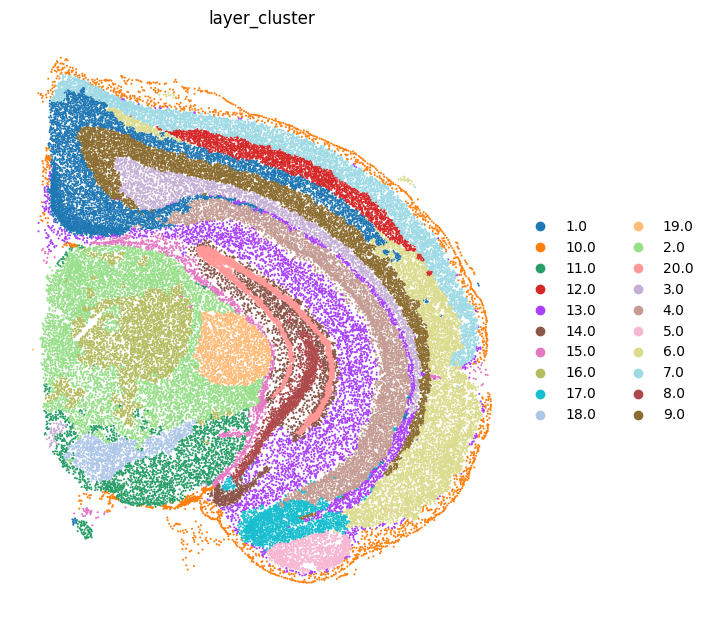

In [11]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import rc_context

with rc_context({'figure.figsize': (6.5,7.5)}):
    sc.pl.embedding(adata1, basis='spatial', color=['layer_cluster'], frameon=False, s=9)

### Analysis of spatial domains

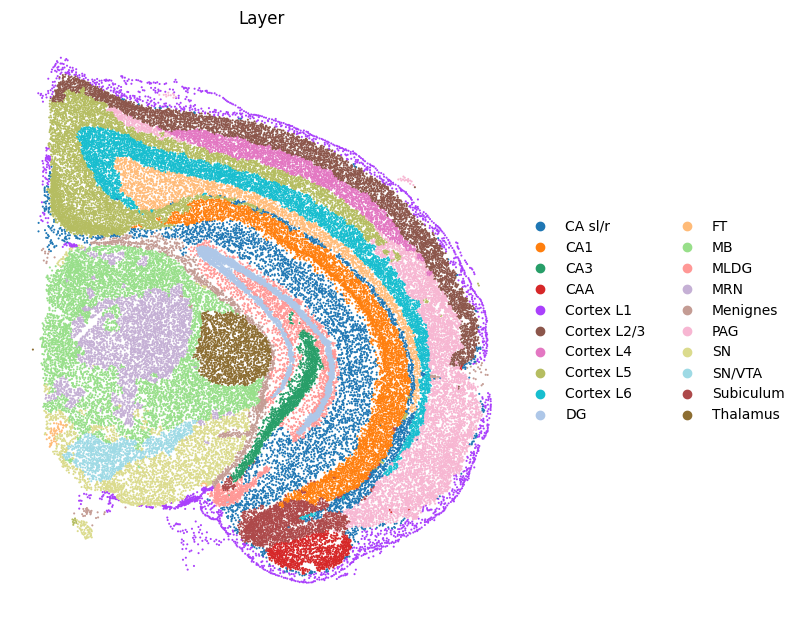

In [12]:
# annotation layers

replace_dict = {'1.0':'Cortex L5', '2.0':'MB', '3.0':'FT', 
                '4.0':'CA1', '5.0':'CAA', '6.0':'PAG', 
                '7.0':'Cortex L2/3', '8.0':'CA3', '9.0':'Cortex L6',
                '10.0':'Cortex L1', '11.0':'SN', '12.0':'Cortex L4',
                '13.0':'CA sl/r', '14.0':'MLDG', '15.0':'Menignes',
                '16.0':'MRN', '17.0':'Subiculum', '18.0':'SN/VTA',
                '19.0':'Thalamus', '20.0':'DG'}
adata1.obs['Layer'] = adata1.obs['layer_cluster'].replace(replace_dict).astype(str).astype('category')

with rc_context({'figure.figsize': (6.5,7.5)}):
    sc.pl.embedding(adata1, basis='spatial', color=['Layer'], frameon=False, s=9)

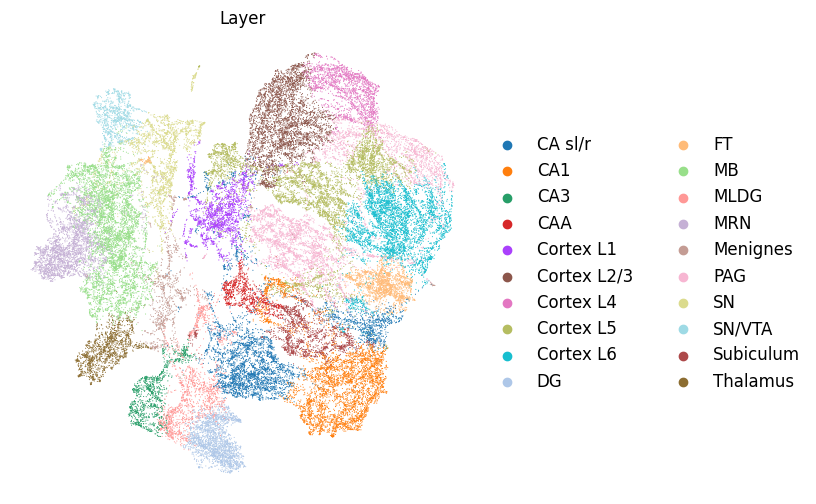

In [13]:
sc.pp.neighbors(adata1, use_rep='X_SE', key_added='X_SE')
adata1.obsm['umap_SE'] = sc.tl.umap(adata1, neighbors_key='X_SE', copy=True).obsm['X_umap']
with rc_context({'figure.figsize': (6,6)}):
    sc.pl.embedding(adata1, color='Layer', basis="umap_SE",
                    frameon=False, wspace=0.4, vmax='p99',legend_fontsize=12)  

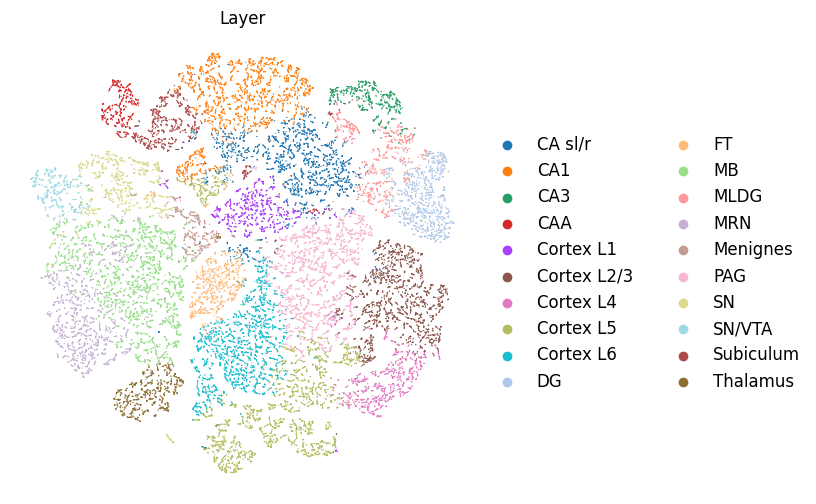

In [14]:
adata1.obsm['tsne_SE'] = sc.tl.tsne(adata1, use_rep='X_SE', copy=True).obsm['X_tsne']
with rc_context({'figure.figsize': (6,6)}):
    sc.pl.embedding(adata1, color='Layer', basis="tsne_SE",
                    frameon=False, wspace=0.4, vmax='p99',legend_fontsize=12)

### Clustering for CE

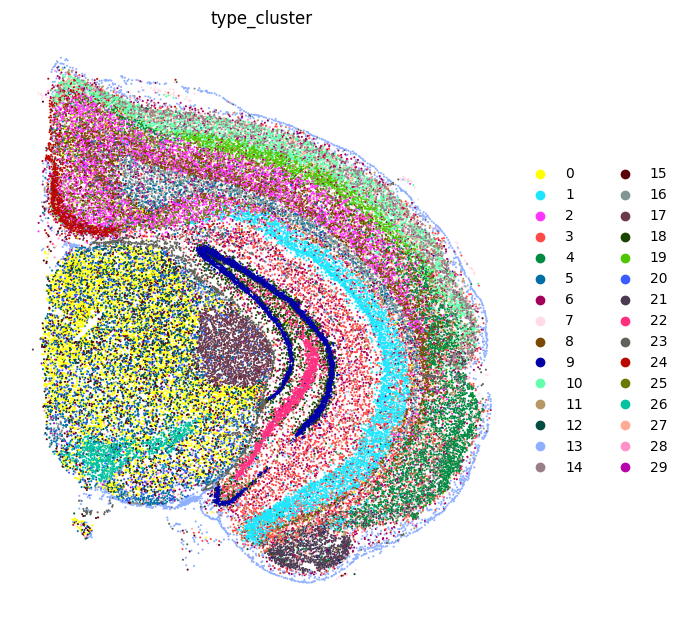

In [15]:
SECE.cluster_func(adata1, clustering='leiden', use_rep='X_CE', res=1.75, key_add='type_cluster')
with rc_context({'figure.figsize': (6.5,7.5)}):
    sc.pl.embedding(adata1, basis='spatial', color=['type_cluster'],
                    frameon=False, s=9)

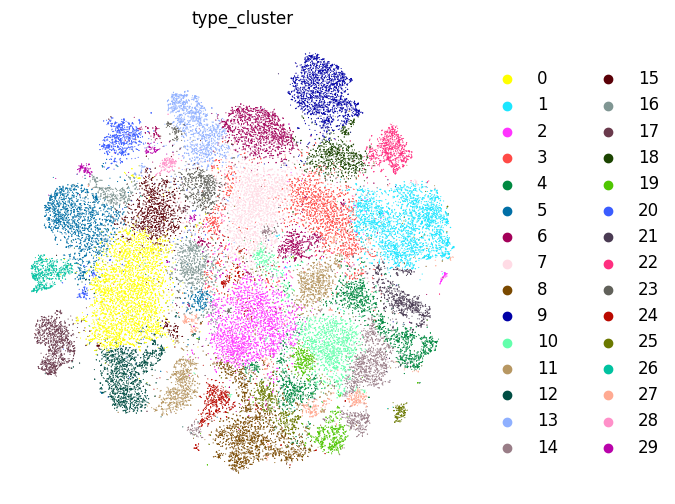

In [22]:
adata1.obsm['tsne_CE'] = sc.tl.tsne(adata1, use_rep='X_CE', copy=True).obsm['X_tsne']
with rc_context({'figure.figsize': (6,6)}):
    sc.pl.embedding(adata1, color='type_cluster', basis="tsne_CE",
                    frameon=False, wspace=0.4, vmax='p99',legend_fontsize=12)

In [16]:
adata1

AnnData object with n_obs × n_vars = 50140 × 18575
    obs: 'annotation', 'x', 'y', 'size', 'n_counts', 'layer_cluster', 'Layer', 'type_cluster'
    var: 'n_cells'
    uns: 'log1p', 'layer_cluster_colors', 'Layer_colors', 'X_SE', 'type_cluster', 'leiden', 'type_cluster_colors'
    obsm: 'spatial', 'X_CE', 'X_SE', 'umap_SE', 'tsne_SE'
    layers: 'counts', 'expr'
    obsp: 'X_SE_distances', 'X_SE_connectivities', 'type_cluster_distances', 'type_cluster_connectivities'

In [17]:
adata1.write(f'{result_path}/adata1.h5ad')